In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve

import lightgbm as lgb
from catboost import CatBoostClassifier
import os
import random
import gc
import re
import warnings
warnings.filterwarnings('ignore')
from gensim.models import Word2Vec
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from collections import defaultdict
import time
from collections import Counter

/Users/v0h0041/Documents/kaggle/env/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
from collections import Counter

def list_intersection(a, b):
    if len(a)>len(b):
        a,b = b,a

    a_count = Counter(a)
    b_count = Counter(b)
    return sum(min(b_count[ak], av) for ak,av in a_count.items())
def list_union(a, b):
    if len(a)>len(b):
        a,b = b,a

    a_count = Counter(a)
    b_count = Counter(b)
    new_dict_union = {}
    new_dict_union = {ak:av for ak, av in a_count.items()}
    for ak, av in b_count.items():
        if ak not in new_dict_union:
            new_dict_union[ak]= av
        else:
            new_dict_union[ak] = new_dict_union[ak]+av 
    return sum(new_dict_union[ak] for ak in new_dict_union.keys())
def label_enc(x):
    values = x.unique()
    lb_enc = defaultdict(np.int32)
    for i, v in enumerate(values):
        lb_enc[v] = i
    return lb_enc, values

def one_hot_enc(df, x):
    values = df[x].unique()
    #values_dict = {v:i for i, v in enumerate(values)}
    
    for v in values:
        df[f'{x}_{v}'] = np.where(df[x] == v, 1, 0)
        df[f'{x}_{v}'] = df[f'{x}_{v}'].astype('int8')
#    one_hot_enc = np.zeros(shape = (len(x), len(values)))
#    for idx, v in enumerate(df[x]):
#        df.loc[idx, f'{x}_{v}'] = 1
#    return df

train_data_path = '../input/train_AUpWtIz/'

def load_data(train_data_path):
        # loading all datasets
    campaign_data = pd.read_csv(os.path.join(train_data_path, 'campaign_data.csv'))
    customer_demographics = pd.read_csv(os.path.join(train_data_path, 'customer_demographics.csv'))
    item_data = pd.read_csv(os.path.join(train_data_path, 'item_data.csv'))
    
    # load train data
    df_train = pd.read_csv(os.path.join(train_data_path, 'train.csv'))
    df_test = pd.read_csv('../input/test_QyjYwdj.csv')
    
#     convert to datetime format
#    customer_transaction['date'] = pd.to_datetime(customer_transaction['date'])
    campaign_data['start_date'] = pd.to_datetime(campaign_data['start_date'], dayfirst=True)
    campaign_data['end_date'] = pd.to_datetime(campaign_data['end_date'], dayfirst=True)
    
    df_train = df_train.join(customer_demographics.set_index('customer_id'), on='customer_id', how='left')
    df_test = df_test.join(customer_demographics.set_index('customer_id'), on='customer_id', how='left')

    df_train = df_train.join(campaign_data.set_index('campaign_id'), on='campaign_id', how='left', rsuffix='_campaign')
    df_test = df_test.join(campaign_data.set_index('campaign_id'), on='campaign_id', how='left', rsuffix='_campaign')
    
    train = df_train.loc[~(df_train.campaign_id.isin([11,12,13]))]
    val = df_train.loc[df_train.campaign_id.isin([11,12,13])]
    del campaign_data, customer_demographics, item_data,df_train 
    gc.collect()
    

    return train,val, df_test

In [3]:
df_train,df_val, df_test = load_data(train_data_path)
print(f'shape of train data {df_train.shape}, shape of val data {df_val.shape},shape of test data {df_test.shape}')
df_train.head()

shape of train data (50431, 14), shape of val data (27938, 14),shape of test data (50226, 13)


,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket,campaign_type,start_date,end_date
2,6,9,635,205,0,46-55,Married,0.0,2,NaN,7.0,Y,2013-03-11,2013-04-12
4,9,8,1017,1489,0,46-55,Married,0.0,2,NaN,3.0,X,2013-02-16,2013-04-05
6,14,9,444,590,0,36-45,NaN,0.0,2,NaN,1.0,Y,2013-03-11,2013-04-12
7,15,29,538,368,0,36-45,NaN,0.0,1,NaN,5.0,Y,2012-10-08,2012-11-30
8,17,30,857,523,0,NaN,NaN,NaN,NaN,NaN,NaN,X,2012-11-19,2013-01-04


In [4]:
def load_transaction(df, apply_list=True):
    
    start_time = time.time()
    customer_transaction = pd.read_csv(os.path.join(train_data_path, 'customer_transaction_data.csv'))
    coupon_item_data = pd.read_csv(os.path.join(train_data_path, 'coupon_item_mapping.csv'))
    customer_transaction['date'] = pd.to_datetime(customer_transaction['date'])
    
    coupon_item = coupon_item_data.groupby('coupon_id')['item_id'].apply(list)
    item_data = pd.read_csv(os.path.join(train_data_path, 'item_data.csv'))
    
    print('joining datasets and filtering')
    df_trans = df[['customer_id', 'campaign_id', 'coupon_id', 'start_date']].join(customer_transaction.set_index('customer_id')
                         , on='customer_id', how='left', rsuffix='_transaction')
    
    df_trans = df_trans.loc[df_trans['start_date'] > df_trans['date']].reset_index(drop=True)
    
    df_trans = df_trans.join(item_data.set_index('item_id'), on='item_id', how='left', rsuffix='_item')
    
#    print('One hot encoding')
    
#     one_hot_enc(df_trans, 'category')
#     one_hot_enc(df_trans, 'brand_type')
    
    agg = dict()
    # need to add features regading other_discount and coupon_discount
#    agg['other_discount'] = ['median', 'std', 'min', 'max']
#    agg['coupon_discount'] = ['median', 'std', 'min', 'max']
    for col in df_trans.columns:
#         if ('category_' in col) | ('brand_type_' in col):
#             agg[col] = 'sum'
        if col == 'item_id':
            agg[col] = list
        elif '_discount' in col:
            agg[col] = 'mean'
    
    print('Group by')
    df_trans_obj = df_trans.groupby(['customer_id', 'campaign_id', 'coupon_id']).agg(agg)
    
    print('joining the datasets')
    df = df.join(df_trans_obj, on=['customer_id', 'campaign_id', 'coupon_id'], how='left', rsuffix='_history')
    df = df.join(coupon_item, on='coupon_id', how='left', rsuffix='_coupon')
    
    del customer_transaction, coupon_item_data
    gc.collect()

        
    df['item_id_intersection_item_id_coupon_list'] = df.apply(lambda x: list_intersection(x.item_id, x.item_id_coupon)
                                                     , axis=1)
    df['item_id_union_item_id_coupon_list'] = df.apply(lambda x: list_union(x.item_id, x.item_id_coupon)
                                                     , axis=1)

    df['item_id_ratio_item_id_coupon_list'] = df['item_id_intersection_item_id_coupon_list']/ \
                                            df['item_id_union_item_id_coupon_list']

    df['item_id_intersection_item_id_coupon'] = df.apply(lambda x: len(set(x.item_id).intersection(x.item_id_coupon))
                                                     , axis=1)

    df['item_id_union_item_id_coupon'] = df.apply(lambda x: len(set(x.item_id).union(x.item_id_coupon))
                                                     , axis=1)
    df['item_id_ratio_item_id_coupon'] = df['item_id_intersection_item_id_coupon']/ \
                                            df['item_id_union_item_id_coupon']
 
    
    df_trans_obj = df_trans.loc[df_trans['coupon_discount'] < 0].groupby(['customer_id'
                                                                          , 'campaign_id'
                                                                         , 'coupon_id']).agg(agg)
    df = df.join(df_trans_obj, on=['customer_id'
                                   , 'campaign_id'
                                  , 'coupon_id']
                 , how='left', rsuffix='_active_coupon')
    
    
    df['item_id_active_coupon'].fillna(-1, inplace=True)

    df['item_id_intersection_item_id_active_list'] = df.apply(lambda x: list_intersection(x.item_id_coupon, x.item_id_active_coupon) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)
    df['item_id_union_item_id_active_list'] = df.apply(lambda x: list_union(x.item_id_coupon, x.item_id_active_coupon) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)

    df['item_id_intersection_prec_list'] = df.apply(lambda x: list_intersection(x.item_id, x.item_id_active_coupon) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)
    df['item_id_union_prec_list'] = df.apply(lambda x: list_union(x.item_id, x.item_id_active_coupon) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)



    df['item_id_ratio_item_id_active_list'] = df['item_id_intersection_item_id_active_list']/ \
                                                df['item_id_union_item_id_active_list']

    df.loc[df.item_id_intersection_item_id_active_list == -1, 'item_id_ratio_item_id_active_list'] = -1

    df['item_id_ratio_prec_list'] = df['item_id_intersection_prec_list']/df['item_id_union_prec_list']

    df['item_id_intersection_item_id_active'] = df.apply(lambda x: len(set(x.item_id_coupon).intersection(x.item_id_active_coupon)) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)
    df['item_id_union_item_id_active'] = df.apply(lambda x: len(set(x.item_id_coupon).union(x.item_id_active_coupon)) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)

    df['item_id_intersection_prec'] = df.apply(lambda x: len(set(x.item_id).intersection(x.item_id_active_coupon)) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)
    df['item_id_union_prec'] = df.apply(lambda x: len(set(x.item_id).union(x.item_id_active_coupon)) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)

    df['item_id_ratio_item_id_active'] = df['item_id_intersection_item_id_active']/df['item_id_union_item_id_active']
    df.loc[df.item_id_intersection_item_id_active == -1, 'item_id_ratio_item_id_active'] = -1

    df['item_id_ratio_prec'] = df['item_id_intersection_prec']/df['item_id_union_prec']
    
    print('Done in time :', time.time()-start_time)
    return df

In [5]:
df_train = load_transaction(df_train)
df_val = load_transaction(df_val)
df_test = load_transaction(df_test)

joining datasets and filtering
Group by
joining the datasets
Done in time : 128.46846222877502
joining datasets and filtering
Group by
joining the datasets
Done in time : 86.68273591995239
joining datasets and filtering
Group by
joining the datasets
Done in time : 249.20717310905457


In [7]:
def train_model(clf, X_train,X_val, y_train,y_val, X_test, **classifier_params):
    
    oof_preds = np.zeros(len(X_train))
    test_preds = []
    imp_df = None
    X_tr = X_train
    X_val = X_val
    y_tr = y_train
    y_val = y_val
    est = clf.set_params(**classifier_params)
    
    est.fit(X_tr, y_tr
            , eval_set = [(X_tr, y_tr), (X_val, y_val)]
            , eval_metric = 'logloss'
            , verbose = 100
            , early_stopping_rounds = 50)
        
    y_val_preds = est.predict_proba(X_val, num_iteration = est.best_iteration_)[:, 1]
    print(f'AUC score : {roc_auc_score(y_val, y_val_preds)}')
        
    oof_preds = y_val_preds
    test_preds.append(est.predict_proba(X_test, num_iteration=est.best_iteration_)[:, 1])

    imp_df = pd.DataFrame()
    imp_df['feature'] = X_tr.columns
    imp_df['gain'] = est.feature_importances_

    return oof_preds, np.mean(test_preds, axis=0), imp_df

In [22]:
cat_feats = ['age_range', 'marital_status'
         , 'rented', 'family_size', 'no_of_children', 'income_bracket',
        'campaign_type','customer_id']
for col in cat_feats:
    if(col!= 'customer_id'):
        df_train[col].fillna(-1, inplace=True)
        df_test[col].fillna(-1, inplace=True)
        lb_enc, _ = label_enc(df_train[col])
        df_train[col] = df_train[col].map(lb_enc)
        df_test[col] = df_test[col].map(lb_enc)
        df_val[col] = df_val[col].map(lb_enc)
    
rm_feats = ['id', 'campaign_id', 'coupon_id','redemption_status','item_id_coupon', 'start_date','end_date','item_id','other_discount',
 'coupon_discount','other_discount_active_coupon','coupon_discount_active_coupon','item_id_active_coupon']
num_feats = [f for f in df_train.columns if f not in rm_feats and f not in cat_feats]


In [23]:
X_train = df_train[cat_feats+num_feats]
y_train = df_train['redemption_status']
X_val = df_val[cat_feats+num_feats]
y_val = df_val['redemption_status']


lgb_params = lgb_params = {
        'random_state':122,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'logloss',
        'learning_rate': 0.002,
        'subsample': .8,
        'colsample_bytree': .8,
        'reg_alpha': 10,
        'reg_lambda': 10,
        'n_estimators': 5000,
        'max_depth': 3
    }
y_val_preds, test_preds, imp_df = train_model(lgb.LGBMClassifier(), X_train,X_val, y_train,y_val,
                                         df_test[cat_feats+num_feats], **lgb_params)


Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376942	valid_1's binary_logloss: 0.0623454
[200]	training's binary_logloss: 0.0348486	valid_1's binary_logloss: 0.0574748
[300]	training's binary_logloss: 0.0329851	valid_1's binary_logloss: 0.0543262
[400]	training's binary_logloss: 0.0317125	valid_1's binary_logloss: 0.0522654
[500]	training's binary_logloss: 0.0307945	valid_1's binary_logloss: 0.050771
[600]	training's binary_logloss: 0.030112	valid_1's binary_logloss: 0.0496824
[700]	training's binary_logloss: 0.0295922	valid_1's binary_logloss: 0.0488231
[800]	training's binary_logloss: 0.0291855	valid_1's binary_logloss: 0.0481923
[900]	training's binary_logloss: 0.028856	valid_1's binary_logloss: 0.0476833
[1000]	training's binary_logloss: 0.0285791	valid_1's binary_logloss: 0.0472903
[1100]	training's binary_logloss: 0.0283483	valid_1's binary_logloss: 0.047009
[1200]	training's binary_logloss: 0.0281497	valid_1's binary_logloss: 0

In [24]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "gain"]].groupby("feature").mean().sort_values(by="gain", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="gain", y="feature", data=best_features.sort_values(by="gain", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
#    plt.savefig('lgbm_importances01.png')

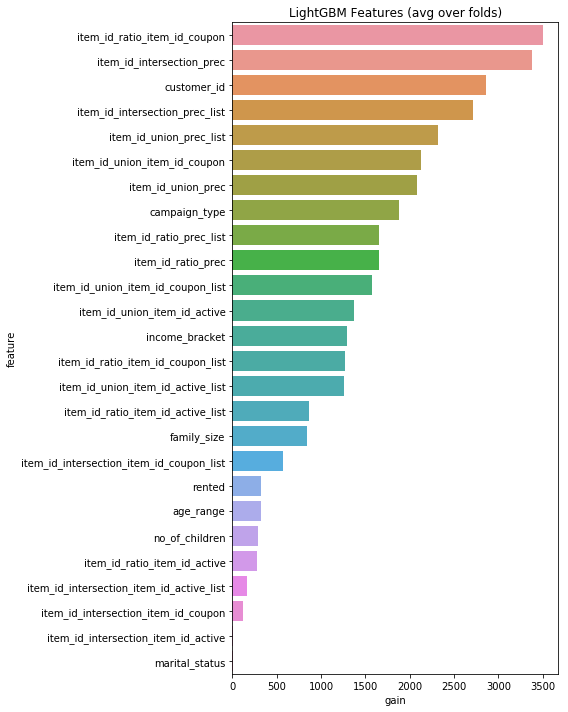

In [25]:
display_importances(imp_df)


In [26]:
sub = pd.read_csv('../input/sample_submission_Byiv0dS.csv')
sub['redemption_status'] = test_preds
sub.head()
sub.to_csv('../submission/5.csv', index=False)

In [ ]:
0.9180629427147886 CV
0.925 LB